In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
data = pl.read_excel('Data/CleanData.xlsx').select('Date', 'CUSIP', 'asset_type', 'credit_rating', 
                                                   'spread', (pl.col('spread') * pl.col('duration')).alias('DTS')).filter(pl.col('spread') != 0)

data = data.sort('Date', 'CUSIP').with_columns((pl.col('spread') - pl.col('spread').shift(1).over('CUSIP')).alias('abs_spread_chg'),
                                               ((pl.col('spread') - pl.col('spread').shift(1).over('CUSIP')) / pl.col('spread')).alias('pct_spread_chg')).drop_nulls().unique()
data = data.filter(pl.col('spread') < pl.col('spread').quantile(0.99), pl.col('spread') > pl.col('spread').quantile(0.01))
data = data.filter(pl.col('asset_type') == 'Credit')

In [8]:
vols = data.sort('Date', 'CUSIP').with_columns(pl.col('abs_spread_chg').rolling_std(36).over('CUSIP').alias('abs_vol'),
                                               pl.col('pct_spread_chg').rolling_std(36).over('CUSIP').alias('pct_vol')).drop_nulls()
excess = vols.with_columns((pl.col('DTS') * pl.col('pct_vol')).alias('excess_return_vol'))
bucket1 = excess['spread'].quantile(0.33) # 71
bucket2 = excess['spread'].quantile(0.66) # 121

spread_buckets = excess.with_columns(pl.when(pl.col('spread') < bucket1)
                           .then(pl.lit('0'))
                        .otherwise(pl.when(pl.col('spread') < bucket2)
                           .then(pl.lit('1'))
                         .otherwise(pl.lit('2'))).alias('bucket'))

spread_buckets = spread_buckets.filter(pl.col('spread') >= 20)

grouped = spread_buckets.group_by('Date', 'bucket').agg(pl.col('abs_vol').mean(), pl.len(), pl.col('DTS').mean(), pl.col('excess_return_vol').mean()).sort('Date')
b0 = grouped.filter(pl.col('len') > 5, pl.col('bucket') == '0').sort('Date')
b1 = grouped.filter(pl.col('len') > 5, pl.col('bucket') == '1').sort('Date')
b2 = grouped.filter(pl.col('len') > 5, pl.col('bucket') == '2').sort('Date')

In [9]:
covid_data = pl.concat([b0, b1, b2])

x = covid_data['DTS'].to_numpy().reshape(-1, 1)
y = covid_data['excess_return_vol'].to_numpy()

X_with_intercept = sm.add_constant(x)  # Add an intercept
statsmodel = sm.OLS(y, X_with_intercept).fit()

# Display p-values
print(statsmodel.summary())

y_pred = statsmodel.predict(X_with_intercept)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     2034.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          7.60e-264
Time:                        16:48:08   Log-Likelihood:                -5978.3
No. Observations:                1244   AIC:                         1.196e+04
Df Residuals:                    1242   BIC:                         1.197e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9957      1.344      6.695      0.0

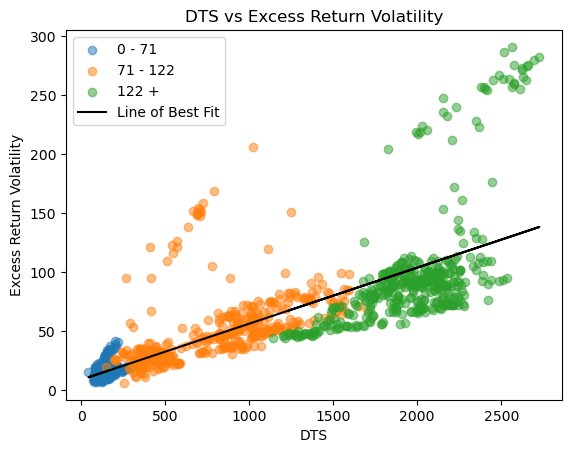

In [10]:
plt.scatter(b0['DTS'], b0['excess_return_vol'], alpha = 0.5, label = '0 - 71')
plt.scatter(b1['DTS'], b1['excess_return_vol'], alpha = 0.5, label = '71 - 122')
plt.scatter(b2['DTS'], b2['excess_return_vol'], alpha = 0.5, label = '122 +')
plt.xlabel('DTS')
plt.ylabel('Excess Return Volatility')
plt.title('DTS vs Excess Return Volatility')
plt.plot(x, y_pred, color = 'black', label = 'Line of Best Fit')
plt.legend()

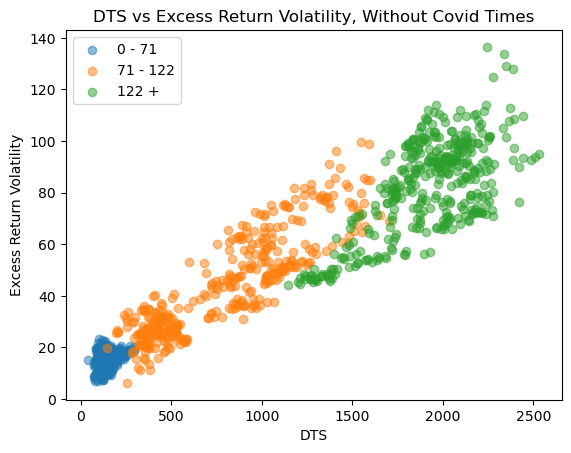

In [5]:
b0_filt = b0.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))
b1_filt = b1.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))
b2_filt = b2.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))

plt.scatter(b0_filt['DTS'], b0_filt['excess_return_vol'], alpha = 0.5, label = '0 - 71')
plt.scatter(b1_filt['DTS'], b1_filt['excess_return_vol'], alpha = 0.5, label = '71 - 122')
plt.scatter(b2_filt['DTS'], b2_filt['excess_return_vol'], alpha = 0.5, label = '122 +')
plt.xlabel('DTS')
plt.ylabel('Excess Return Volatility')
plt.title('DTS vs Excess Return Volatility, Without Covid Times')
plt.legend()

In [6]:
filtered_data = pl.concat([b0_filt, b1_filt, b2_filt])

x = filtered_data['DTS'].to_numpy().reshape(-1, 1)
y = filtered_data['excess_return_vol'].to_numpy()

X_with_intercept = sm.add_constant(x)  # Add an intercept
statsmodel = sm.OLS(y, X_with_intercept).fit()

# Display p-values
print(statsmodel.summary())

y_pred = statsmodel.predict(X_with_intercept)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     9854.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:47:08   Log-Likelihood:                -4157.0
No. Observations:                1115   AIC:                             8318.
Df Residuals:                    1113   BIC:                             8328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5912      0.487     21.756      0.0

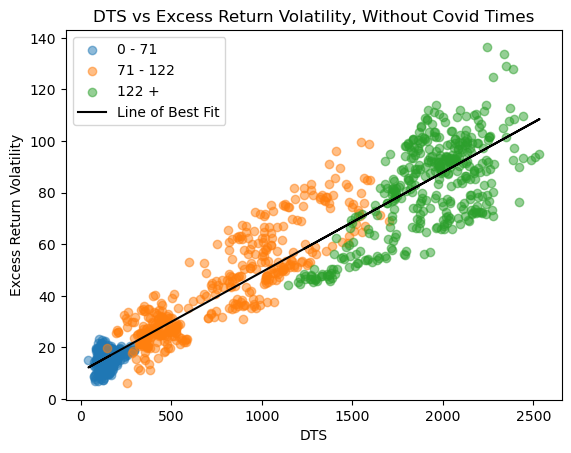

In [7]:
plt.scatter(b0_filt['DTS'], b0_filt['excess_return_vol'], alpha = 0.5, label = '0 - 71')
plt.scatter(b1_filt['DTS'], b1_filt['excess_return_vol'], alpha = 0.5, label = '71 - 122')
plt.scatter(b2_filt['DTS'], b2_filt['excess_return_vol'], alpha = 0.5, label = '122 +')
plt.plot(x, y_pred, color = 'black', label = 'Line of Best Fit')
plt.xlabel('DTS')
plt.ylabel('Excess Return Volatility')
plt.title('DTS vs Excess Return Volatility, Without Covid Times')
plt.legend()

In [17]:
model.coef_

array([0.03864684])

In [18]:
model.intercept_

10.591232654307667

In [27]:
X_with_intercept = sm.add_constant(x)  # Add an intercept
statsmodel = sm.OLS(y, X_with_intercept).fit()

# Display p-values
print(statsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     9854.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:36:27   Log-Likelihood:                -4157.0
No. Observations:                1115   AIC:                             8318.
Df Residuals:                    1113   BIC:                             8328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5912      0.487     21.756      0.0

In [29]:
statsmodel.predict(X_with_intercept)

array([16.7353662 , 16.39692671, 14.97061129, ..., 60.39954938,
       58.31231345, 58.42888275])